Copyright 2025. Jungwoo Kim. All rights reserved.<br>
Complex System Design Laboratory<br>
Dept. of Industrial & Systems Engineering, KAIST

# Import Libraries

In [236]:
import numpy as np
from tqdm import tqdm
import random
import pandas as pd
import math
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import easydict
from scipy.spatial.distance import euclidean
from scipy.spatial import distance_matrix
from scipy.interpolate import griddata
from shapely.geometry import Point, MultiPolygon, Polygon
import geopandas as gpd
import openpyxl
from easydict import EasyDict
from tqdm import tqdm
from sklearn.neighbors import KDTree
from descartes import PolygonPatch
import matplotlib.colors as mcolors
from pyproj import Proj, transform
import seaborn as sns
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)

proj_tm_mid = Proj(init='epsg:2097')
proj_wgs84 = Proj(init='epsg:4326')

plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] = False

np.random.seed(42)
random.seed(4242)

# Tool Functions

In [215]:
def random_points_in_multipolygon(shape, num_points):
    if isinstance(shape, Polygon):
        min_x, min_y, max_x, max_y = shape.bounds
    else:
        min_x, min_y, max_x, max_y = shape.geoms[0].bounds
        for i in range(1,len(shape.geoms)):
            polygon = shape.geoms[i]
            min_x_i, min_y_i, max_x_i, max_y_i = polygon.bounds
            if min_x_i<min_x:
                min_x = min_x_i
            if min_y_i<min_y:
                min_y = min_y_i
            if max_x_i>max_x:
                max_x = max_x_i
            if max_y_i>max_y:
                max_y = max_y_i
    # 좌표 설정
    points = []
    while len(points) < num_points:
        point = Point(random.uniform(min_x, max_x), random.uniform(min_y, max_y))
        if isinstance(shape, Polygon):
            if shape.contains(point):
                    points.append(point)
        else:
            for i in range(len(shape.geoms)):
                polygon = shape.geoms[i]
                if polygon.contains(point):
                    points.append(point)
            
    return points

# Geographical Setting

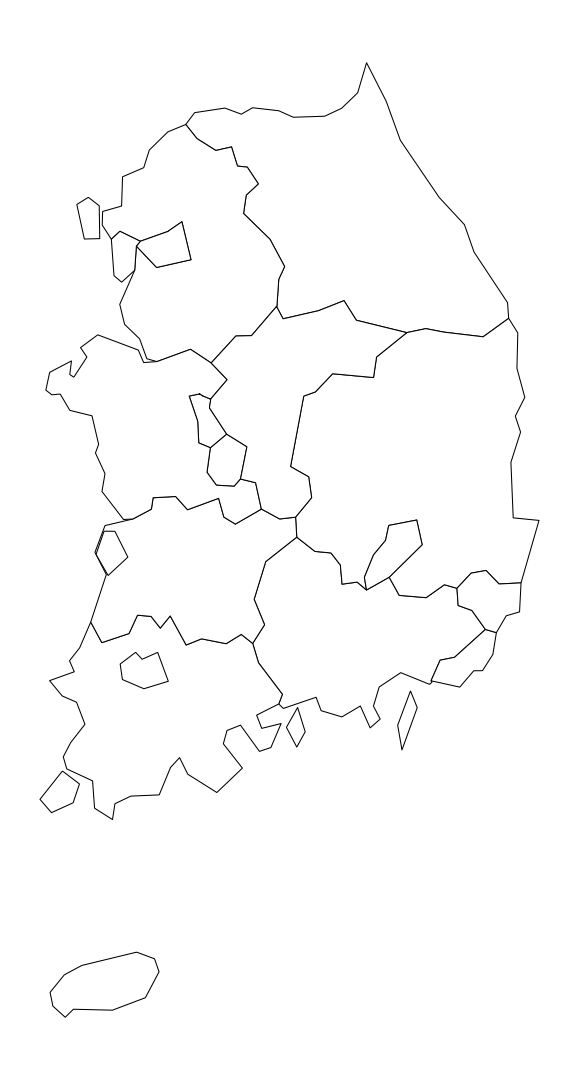

In [216]:
# shp 파일 로드
# filepath_shp_simplified = '/Users/jungwoo/Library/Mobile Documents/com~apple~CloudDocs/Research Project/Assets/shapefiles_korea_simplified/TL_SCCO_CTPRVN/'
geo_file = 'Korea_shapefiles/TL_SCCO_CTPRVN.shp'
gdf = gpd.read_file(geo_file, encoding='euc-kr')
outside_polygon_mask = np.load("outside_polygon_mask.npy")

gdf.CTP_KOR_NM = [
    '강원',
    '경기',
    '경남',
    '경북',
    '광주',
    '대구',
    '대전',
    '부산',
    '서울',
    '세종',
    '울산',
    '인천',
    '전남',
    '전북',
    '제주',
    '충남',
    '충북'
]

# Manual modifications

coords1 = [(126.59156455632241, 37.593011823985485), (126.6512526639701, 37.63798791865732),
           (126.79369544519706, 37.58159385885768), (126.7662043574505, 37.554242375748366),
           (126.7544652746883, 37.41757293948264), (126.66344966004381, 37.35053506629968),
           (126.60996708541704, 37.38718717658724), (126.59156455632241, 37.593011823985485)]
coords2 = [(126.43121685572747, 37.82986908194544), (126.35057985274231, 37.789565062650894),
           (126.40316813158975, 37.59428252797514), (126.51062866491168, 37.59662373953827),
           (126.5068975008081, 37.78234762310096), (126.43121685572747, 37.82986908194544)]
polygon1 = Polygon(coords1)
polygon2 = Polygon(coords2)
gdf.loc[11,'geometry'] = MultiPolygon([polygon1, polygon2])
coords1 = [(126.16122307201523, 36.84077447960923), (126.1346055789919, 36.740324711760486),
           (126.17654567314271, 36.71395826078249), (126.23492459115923, 36.71807007755431),
           (126.30206037378963, 36.62590094644257), (126.45646406403513, 36.595210697608685),
           (126.50292188756616, 36.43400816610959), (126.48058601093365, 36.38503110228303),
           (126.54732360572413, 36.2683451886003), (126.52610700099113, 36.167672899104176),
           (126.67649645277267, 36.00923289097959), (126.74156052854424, 36.0119448809583),
           (126.87081796412734, 36.06740464723523), (126.88282411119397, 36.13207402130215),
           (127.04003005195446, 36.13933847885477), (127.12318778724037, 36.06424768168607),
           (127.34009324309051, 36.128979280260644), (127.37649530932696, 36.02288908915842),
           (127.45674606514737, 35.983276216973415), (127.63829543249358, 36.06793987054469),
           (127.63791587136105, 36.06890166403231), (127.59802031438574, 36.21708890108369),
           (127.49257720191125, 36.23795395068193), (127.44871641082584, 36.19672289194393),
           (127.32394583489626, 36.203158372814976), (127.25877186484053, 36.2760505815688),
           (127.28212428234082, 36.414603964631645), (127.20138964906599, 36.44197527604719),
           (127.19378772255222, 36.564812513911036), (127.13437853561463, 36.7067919896922),
           (127.20793603234716, 36.71918904581354), (127.20792754283481, 36.71917583461923),
           (127.20792684751393, 36.71917607776152), (127.20787710929177, 36.71918850565105),
           (127.2078769797854, 36.71919046333673), (127.20787710929177, 36.71918850565105),
           (127.20792754283481, 36.71917583461923), (127.20789089293503, 36.719119287386114),
           (127.22822551880574, 36.708468998779054), (127.22822008391248, 36.70845514952263),
           (127.22822551880574, 36.708468998779054), (127.22823057936279, 36.70846556314337),
           (127.28126367067202, 36.69057059579415), (127.28125389722467, 36.69051337150437),
           (127.28126367067202, 36.69057059579415), (127.28127028658162, 36.69055905464245),
           (127.28529006643944, 36.690671454249056), (127.39951636598008, 36.7992190104284),
           (127.28782886465115, 36.893778879374906), (127.14366362142856, 36.97105116272797),
           (126.90970519398604, 36.90160135376443), (126.8169656460083, 36.8961446522021),
           (126.77958940321619, 36.96680085646616), (126.49675135100698, 37.052811981614845),
           (126.37649095830157, 36.9806341203674), (126.42112642747156, 36.92727201106454),
           (126.32973391103106, 36.81358358482278), (126.30162178982232, 36.82841928228409),
           (126.31328915259776, 36.90549865703278), (126.16122307201523, 36.84077447960923)]
gdf.loc[15,'geometry'] = Polygon(coords1)

# Visualize
fig, ax = plt.subplots(figsize=(10, 7), 
                           gridspec_kw={'left': 0, 'right': 1, 'bottom': 0, 'top': 1}, 
                           dpi=150)
gdf.plot(ax=ax, color='w', linewidth=0.5, edgecolor='black', alpha=1)
ax.axis('off')
plt.show()

# Class codes

## Class Simulation

In [217]:
class Simulation:
    def __init__(self, parameter_set):
        self.parameter_set = parameter_set
        self.df_city_info = parameter_set.df_city_info
        self.df_hospital_crd = parameter_set.df_hospital_crd

        self.num_population = sum(self.parameter_set.df_city_info[self.parameter_set.target_population_column])
        self.num_hospital = sum(self.parameter_set.df_city_info['NUM_HOSPITAL'])

        self.arr_population_PHQ = np.full((self.num_population,self.num_hospital), -1.0)
        self.arr_population_PRQ = np.full((self.num_population,len(self.parameter_set.dict_parameter_initial_PRQ)), -1.0)
        self.arr_population_CancerOrNot = np.full(self.num_population, False)

        self.max_quality = parameter_set.max_quality
        self.min_quality = parameter_set.min_quality

    def initialize(self):
        self.create_Cities()
        self.create_Hospitals()
        self.create_People()
        self.set_person_neighbors()

    def execute(self):
        self.set_OHQ()
        self.set_person_initial_perception()
        self.create_Archive()
        self.run_simulation()

    def create_Cities(self):
        self.arr_City_NM = self.df_city_info.SIDO_NM.values
        self.arr_City = np.array([])

        for idx_city in range(len(self.arr_City_NM)):
            nm_city = self.arr_City_NM[idx_city]
            df_city_parameter = self.df_city_info.loc[self.df_city_info.SIDO_NM == nm_city]
            parameter_set_city = EasyDict({
                'idx_city' : idx_city,
                'nm_city' : nm_city,

                'population_real' : df_city_parameter.POPULATION_REAL.values[0],
                'num_population' : df_city_parameter[self.parameter_set.target_population_column].values[0],
                'num_hospital' : df_city_parameter.NUM_HOSPITAL.values[0],
                'nm_region' : df_city_parameter.REGION.values[0],
                })
            self.arr_City = np.append(self.arr_City, City(parameter_set_city))
    
    def create_Hospitals(self):
        self.arr_Hospital = np.array([])
        self.df_Hospital_info = pd.DataFrame({'idx_hospital' : range(self.df_city_info.NUM_HOSPITAL.sum())})
        self.df_Hospital_info['nm_city'] = ''
        self.df_Hospital_info['idx_city'] = 0
        self.df_Hospital_info['coord'] = Point(0,0)
        self.df_Hospital_info['OQ_objective_quality'] = -1.0

        idx_hospital = 0
        self.idx_hospital_in_region = [[],[],[],[],[]]

        for idx_city in range(len(self.arr_City_NM)):
            nm_city = self.arr_City_NM[idx_city]
            df_hospital_crd_city = self.df_hospital_crd.loc[self.df_hospital_crd.SIDO_NM == nm_city]
            arr_idx_hospital_incity = np.array([], dtype=int)

            for idx_hospital_incity in range(self.arr_City[idx_city].num_hospital):
                nm_hospital = df_hospital_crd_city.iloc[idx_hospital_incity].INST_NM
                hospital_crd = Point(transform(proj_tm_mid, proj_wgs84, 
                                              df_hospital_crd_city.iloc[idx_hospital_incity].loc['CRD_X'], 
                                              df_hospital_crd_city.iloc[idx_hospital_incity].loc['CRD_Y']))
                parameter_set_hospital = EasyDict({
                    'idx_hospital' : idx_hospital,
                    'nm_hospital' : nm_hospital,
                    'idx_city' : idx_city,
                    'nm_city' : nm_city,
                    'nm_hospital' : nm_hospital,
                    'coord' : hospital_crd
                    })
                self.arr_Hospital = np.append(self.arr_Hospital, Hospital(parameter_set_hospital))
                arr_idx_hospital_incity = np.append(arr_idx_hospital_incity, idx_hospital)

                self.df_Hospital_info.loc[idx_hospital, 'nm_hospital'] = nm_hospital
                self.df_Hospital_info.loc[idx_hospital, 'nm_city'] = nm_city
                self.df_Hospital_info.loc[idx_hospital, 'idx_city'] = idx_city
                self.df_Hospital_info.loc[idx_hospital, 'coord'] = hospital_crd
                idx_hospital += 1

            self.arr_City[idx_city].arr_idx_hospital_incity = arr_idx_hospital_incity
        
        self.df_Hospital_info = pd.merge(self.df_Hospital_info, self.df_city_info[['SIDO_NM', 'REGION']], how='left', left_on = 'nm_city', right_on = 'SIDO_NM')
        region_mapping = {}
        for idx in range(len(self.parameter_set.dict_parameter_initial_PRQ)):
            region_mapping[list(self.parameter_set.dict_parameter_initial_PRQ.keys())[idx]] = idx
        self.df_Hospital_info['idx_REGION'] = self.df_Hospital_info['REGION'].map(region_mapping)

        for idx_REGION in range(len(region_mapping.keys())):
            self.idx_hospital_in_region[idx_REGION] = self.df_Hospital_info.loc[self.df_Hospital_info.idx_REGION == idx_REGION, 'idx_hospital'].values
    
    def create_People(self):
        self.arr_Person = np.array([])

        self.df_Person_info = pd.DataFrame({'idx_person' : range(self.df_city_info[self.parameter_set.target_population_column].sum())})
        self.df_Person_info['nm_city'] = ''
        self.df_Person_info['idx_city'] = 0
        self.df_Person_info['coord'] = Point(0,0)
        self.df_Person_info['is_cancerpatient'] = False
        self.df_Person_info['idx_chosen_hospital'] = -1
        self.df_Person_info['idx_region_chosen_hospital'] = -1
        self.set_base_PHQ()
        idx_person = 0

        for idx_city in range(len(self.arr_City_NM)):
            nm_city = self.arr_City_NM[idx_city]
            df_city_parameter = self.df_city_info.loc[self.df_city_info.SIDO_NM == nm_city]

            arr_idx_person_incity = np.array([], dtype=int)

            geom_city = gdf.loc[gdf.CTP_KOR_NM == nm_city].iloc[0].geometry
            random_coords = random_points_in_multipolygon(gdf.loc[gdf.CTP_KOR_NM == nm_city].iloc[0].geometry, self.arr_City[idx_city].num_population)
            
            for idx_person_incity in range(self.arr_City[idx_city].num_population):
                parameter_set_person = EasyDict({                
                    'idx_person' : idx_person,
                    'is_cancerpatient' : False,
                    'is_new_cancerpatient' : False,
                    
                    'idx_city' :    idx_city,
                    'nm_city' :     nm_city,
                    'coord' :       random_coords[idx_person_incity],
                    'dict_parameter_initial_PRQ' : self.parameter_set.dict_parameter_initial_PRQ,

                    'sigma_OHQ' :   self.parameter_set.sigma_OHQ,
                    'sigma_OHQ' :   self.parameter_set.sigma_OHQ,
                    'sigma_PRQ' :   self.parameter_set.sigma_PRQ,

                    'beta_PQ' :     self.parameter_set.beta_PQ,
                    'beta_d' :      self.parameter_set.beta_d,
                    'delta' :       self.parameter_set.delta,
                    'pi' :          self.parameter_set.pi,
                    
                    'df_Hospital_info' : self.df_Hospital_info,
                    'df_Person_info' : self.df_Person_info,
                    'idx_hospital_in_region' : self.idx_hospital_in_region,

                    'arr_population_PHQ' : self.arr_population_PHQ,
                    'arr_population_PRQ' : self.arr_population_PRQ,
                    'arr_population_CancerOrNot' : self.arr_population_CancerOrNot,

                    'base_PHQ' : self.base_PHQ
                    })
                

                self.arr_Person = np.append(self.arr_Person, Person(parameter_set_person, self.parameter_set))
                arr_idx_person_incity = np.append(arr_idx_person_incity, idx_person)
                self.df_Person_info.loc[idx_person, 'nm_city'] = nm_city
                self.df_Person_info.loc[idx_person, 'idx_city'] = idx_city
                self.df_Person_info.loc[idx_person, 'coord'] = random_coords[idx_person_incity]
                self.df_Person_info.loc[idx_person, 'is_cancerpatient'] = parameter_set_person.is_cancerpatient
                idx_person += 1
            
            # 각 도시의 인구 idx 넣어주기
            self.arr_City[idx_city].arr_idx_person_incity = arr_idx_person_incity

        self.df_Person_info = pd.merge(self.df_Person_info, 
                                       self.df_city_info[['SIDO_NM', 'REGION']],
                                       how='left', left_on = 'nm_city', right_on = 'SIDO_NM')


    def create_Archive(self):
        self.achv_population_is_cancerpatient = np.full((self.parameter_set.max_dt, self.num_population), False)
        self.achv_population_is_cancerpatient[0] = self.df_Person_info.is_cancerpatient.values

        self.achv_population_choice_prob = np.full((self.parameter_set.max_dt, self.num_population, self.num_hospital), 0.0)
        self.achv_population_PRQ = np.full((self.parameter_set.max_dt, self.num_population, len(self.parameter_set.dict_parameter_initial_PRQ)), 0.0)
        self.achv_population_PHQ = np.full((self.parameter_set.max_dt, self.num_population, self.num_hospital), 0.0)
        self.achv_population_True_Utility = np.full((self.parameter_set.max_dt, self.num_population, self.num_hospital), 0.0)
        self.achv_OHQ = np.full((self.parameter_set.max_dt, self.num_hospital), 0.0)

        for idx_person in self.df_Person_info.idx_person.values:
            self.achv_population_choice_prob[0,idx_person] = self.arr_Person[idx_person].choice_prob
            self.achv_population_PRQ[0,idx_person] = self.arr_Person[idx_person].PRQ
            self.achv_population_PHQ[0,idx_person] = self.arr_Person[idx_person].PHQ
        self.achv_OHQ[0] = self.df_Hospital_info.OQ_objective_quality.values


    def update_Archive(self, dt):
        self.achv_population_is_cancerpatient[dt] = self.df_Person_info.is_cancerpatient.values
        for idx_person in self.df_Person_info.idx_person.values:
            self.achv_population_choice_prob[dt,idx_person] = self.arr_Person[idx_person].choice_prob
            self.achv_population_PRQ[dt,idx_person] = self.arr_Person[idx_person].PRQ
            self.achv_population_PHQ[dt,idx_person] = self.arr_Person[idx_person].PHQ
        self.achv_OHQ[dt] = self.df_Hospital_info.OQ_objective_quality.values

# Initial Setting
    def set_OHQ(self):
        for idx_hospital, row in self.df_Hospital_info.iterrows():
            nm_region = row['REGION']
            initial_OHQ = self.parameter_set.dict_parameter_initial_OHQ[nm_region] + np.random.normal(0, self.parameter_set.sigma_OHQ)

            self.arr_Hospital[idx_hospital].OQ_obj_quality = initial_OHQ
            self.df_Hospital_info.loc[idx_hospital, 'OQ_objective_quality'] = initial_OHQ

    def set_person_initial_perception(self):
        # Calculate Initial PHQ, PRQ, distance effect
        for idx_person in self.df_Person_info.idx_person.values:

            # Calculate Initial PHQ for each hospital
            self.arr_Person[idx_person].calculate_initial_PHQ()
            self.arr_population_PHQ[idx_person,:] = self.arr_Person[idx_person].PHQ     # Update df_PHQ
            # Calculate Initial PRQ for each region
            self.arr_Person[idx_person].calculate_initial_PRQ()
            self.arr_population_PRQ[idx_person,:] = self.arr_Person[idx_person].PRQ     # Update df_PHQ
            

            # Calculate distance array to each hospitals
            self.arr_Person[idx_person].calculate_distance_effect()

            # Calculate utility to each hospitals
            self.arr_Person[idx_person].calculate_utility()
            # Calculate choice probability to each hospitals
            self.arr_Person[idx_person].calculate_choice_prob()

            # Cancer Patient choose their hospitals
            if self.arr_Person[idx_person].is_new_cancerpatient:
                self.arr_Person[idx_person].choose_hospital()

            self.arr_Person[idx_person].df_Person_info = self.df_Person_info


    def set_person_neighbors(self):
        coords_people = np.array([[point.x, point.y] for point in self.df_Person_info.coord.values])
        kdtree = KDTree(coords_people)
        nearest_neighbors_indices = kdtree.query(coords_people, k=max(self.parameter_set.n_s, 
                                                                      self.parameter_set.n_c), 
                                                 return_distance=False)[:, 1:]

        for idx_person in range(len(self.arr_Person)):
            self.arr_Person[idx_person].list_idx_neighbor_susceptible = nearest_neighbors_indices[idx_person,:self.parameter_set.n_s]
            self.arr_Person[idx_person].list_dist_neighbor_susceptible = [self.df_Person_info.loc[idx_person].coord.distance(self.df_Person_info.loc[idx_neighbor].coord) for idx_neighbor in nearest_neighbors_indices[idx_person,:self.parameter_set.n_s]]
            self.arr_Person[idx_person].list_idx_neighbor_cancer = nearest_neighbors_indices[idx_person,:self.parameter_set.n_c]
            self.arr_Person[idx_person].list_dist_neighbor_cancer = [self.df_Person_info.loc[idx_person].coord.distance(self.df_Person_info.loc[idx_neighbor].coord) for idx_neighbor in nearest_neighbors_indices[idx_person,:self.parameter_set.n_c]]

    def set_base_PHQ(self):
        self.base_PHQ = np.zeros(len(self.df_Hospital_info))
        for region in self.parameter_set.dict_parameter_initial_PRQ.keys():
            self.base_PHQ[self.df_Hospital_info.loc[self.df_Hospital_info.REGION == region].index] = self.parameter_set.dict_parameter_initial_PRQ[region]

    def designate_new_cancerpatient(self):
        self.idx_new_patient = np.random.choice(self.df_Person_info['idx_person'].values, 
                                    size=self.parameter_set.n_p, 
                                    replace=False)
        for idx_person in self.idx_new_patient:
            self.arr_Person[idx_person].is_cancerpatient = True
            self.arr_Person[idx_person].is_new_cancerpatient = True
            self.arr_Person[idx_person].calculate_choice_prob()
            self.arr_Person[idx_person].choose_hospital()
            self.arr_population_CancerOrNot[idx_person] = True
        
        self.df_Person_info.loc[self.df_Person_info.idx_person.isin(self.idx_new_patient), 'is_cancerpatient'] = True


    def run_simulation(self):
        for dt in tqdm(range(1, self.parameter_set.max_dt)):

            self.designate_new_cancerpatient()

            # Information provision
            if self.parameter_set.prov_type > 0:
                self.Information_Provision_Policy(dt)
                for idx_person in range(len(self.arr_Person)):
                    self.arr_population_PHQ[idx_person] = self.arr_Person[idx_person].PHQ
                    self.arr_population_PRQ[idx_person] = self.arr_Person[idx_person].PRQ

            for idx_person in range(len(self.arr_Person)):
                self.arr_Person[idx_person].WOM_PHQ(dt)
                self.arr_population_PHQ[idx_person] = self.arr_Person[idx_person].PHQ
                self.arr_Person[idx_person].WOM_PRQ(dt)
                self.arr_population_PRQ[idx_person] = self.arr_Person[idx_person].PRQ
            
            for idx_person in range(len(self.arr_Person)):
                self.arr_Person[idx_person].calculate_choice_prob()

            self.scale_effect(dt)
            self.update_Archive(dt)


# Scale Effect
    def scale_effect(self, dt):
        mean_hospital_choice_prob = np.mean(self.achv_population_choice_prob[dt-1], axis=0)
        surplus_choice_prob = mean_hospital_choice_prob - np.mean(mean_hospital_choice_prob)
        boundary_smoothing_factor = np.abs(np.array([
                                    np.min((self.df_Hospital_info.OQ_objective_quality.values[i] - self.min_quality, 
                                        self.max_quality - self.df_Hospital_info.OQ_objective_quality.values[i]))
                                        for i in range(len(self.df_Hospital_info))])) / \
                                        (self.max_quality - self.min_quality) * 2 # (0~1)

        new_OHQ = (1 + surplus_choice_prob * self.parameter_set.mu_scale * boundary_smoothing_factor) * \
                    self.df_Hospital_info.OQ_objective_quality.values
        new_OHQ[np.where(new_OHQ>self.max_quality)] = self.max_quality
        new_OHQ[np.where(new_OHQ<self.min_quality)] = self.min_quality
        self.df_Hospital_info.OQ_objective_quality = new_OHQ

# Information Provision
    def Information_Provision_Policy(self, dt):
        idx_susceptible = np.array(list(set(self.df_Person_info['idx_person'].values) - set(self.idx_new_patient)))
        idx_susceptible_info_prov = np.random.choice(idx_susceptible, 
                                                     size=int(np.round(len(idx_susceptible) * 
                                                                       self.parameter_set.gamma_s)), 
                                                                       replace=False)
        idx_patient_info_prov = np.random.choice(self.idx_new_patient,
                                                 size=int(np.round(len(self.idx_new_patient) * 
                                                                   self.parameter_set.gamma_c)),
                                                 replace=False)

        # Regional-level IPP
        if self.parameter_set.prov_type == 1:
            temp_PRQ = self.df_Hospital_info.groupby('idx_REGION')['OQ_objective_quality'].mean().values
            for idx_person in np.concatenate((idx_susceptible_info_prov, idx_patient_info_prov)):
                self.arr_Person[idx_person].PRQ = np.random.normal(temp_PRQ, 
                                                    self.parameter_set.sigma_ip, 
                                                    len(temp_PRQ))
        
        # Hospital-level IPP
        if self.parameter_set.prov_type == 2:
            for idx_person in np.concatenate((idx_susceptible_info_prov, idx_patient_info_prov)):
                self.arr_Person[idx_person].PHQ = np.random.normal(self.achv_OHQ[dt-1], 
                                                    self.parameter_set.sigma_ip, 
                                                    len(self.df_Hospital_info))


## Class City

In [218]:
class City:
    def __init__(self, parameter_set):
        self.parameter_set = parameter_set
        self.idx = parameter_set.idx_city
        self.nm_region = parameter_set.nm_region
        self.nm = parameter_set.nm_city
        
        self.num_population_real = parameter_set.population_real
        self.num_population = parameter_set.num_population
        self.num_cancer_susceptible = self.num_population

        self.num_hospital = parameter_set.num_hospital

        self.coord_centroid = Point(0,0)

        self.arr_idx_person_incity = np.array([])
        self.arr_idx_hospital_incity = np.array([])

## Class Hospital

In [219]:
class Hospital:
    def __init__(self, parameter_set):
        self.parameter_set = parameter_set
        self.idx_city = -1
        self.nm_city = ""
        self.nm_hospital = ""

        self.OQ_obj_quality = 0
        
        self.coord = parameter_set.coord

## Class Person

In [220]:
class Person:
    def __init__(self, parameter_set, parameter_set_simulation):
        self.parameter_set = parameter_set
        self.parameter_set_simulation = parameter_set_simulation
        self.df_Hospital_info = parameter_set.df_Hospital_info
        self.df_Person_info = parameter_set.df_Person_info
        self.idx_hospital_in_region = parameter_set.idx_hospital_in_region

        # Personal info
        self.idx_person = parameter_set.idx_person
        self.is_cancerpatient = parameter_set.is_cancerpatient
        self.is_new_cancerpatient = parameter_set.is_new_cancerpatient
        self.idx_city = parameter_set.idx_city
        self.nm_city = parameter_set.nm_city
        self.coord = parameter_set.coord
        self.pi = self.parameter_set_simulation.pi

        # PHQ, PRQ
        self.dict_parameter_initial_PRQ = parameter_set.dict_parameter_initial_PRQ
        self.PHQ = np.array([])
        self.PRQ = np.array([])
        self.sigma_OHQ = parameter_set.sigma_OHQ
        self.sigma_PRQ = parameter_set.sigma_PRQ
        
        self.arr_population_PHQ = parameter_set.arr_population_PHQ
        self.arr_population_PRQ = parameter_set.arr_population_PRQ
        self.arr_population_CancerOrNot = parameter_set.arr_population_CancerOrNot

        self.max_quality = self.parameter_set_simulation.max_quality
        self.min_quality = self.parameter_set_simulation.min_quality

        # Distance effects
        self.arr_distance_to_hospital = np.array([])
        self.arr_distance_effect = np.array([])

        # Hospital Choice Coefficients
        self.beta_PQ = parameter_set.beta_PQ
        self.beta_d = parameter_set.beta_d
        self.delta = parameter_set.delta

        # Utility, Choice
        # self.Utility = np.zeros(len(self.df_Hospital_info))
        self.arr_utility_region = np.zeros(len(self.df_Hospital_info))
        self.arr_utility_hospital = np.zeros(len(self.df_Hospital_info))

        self.choice_prob = np.zeros(len(self.df_Hospital_info))
        self.idx_choice_hospital = -1

        # WOM Target
        self.list_idx_neighbor = []
        
        # WOM : Hospital Quality
        self.Q_h = np.full((self.parameter_set_simulation.max_dt,
                            len(self.df_Hospital_info)), -1.0)
        self.C_h = np.full((self.parameter_set_simulation.max_dt,
                            len(self.df_Hospital_info)), -1.0)
        self.S_h = np.full((self.parameter_set_simulation.max_dt,
                            len(self.df_Hospital_info)), -1.0)
        self.E_h = np.full((self.parameter_set_simulation.max_dt,
                            len(self.df_Hospital_info)), -1.0)
            # noise
        self.sigma_wom = self.parameter_set_simulation.sigma_wom
            # C : Direct WOM from Cancer Patient
        self.mu_hc = self.parameter_set_simulation.mu_hc
        self.lambda_c = self.parameter_set_simulation.lambda_c
            # S : Direct WOM from Susceptible
        self.mu_hs = self.parameter_set_simulation.mu_hs
        self.lambda_s = self.parameter_set_simulation.lambda_s
            # E : Experience based Realization
        self.mu_recog = self.parameter_set_simulation.mu_recog
        self.sigma_recog = self.parameter_set_simulation.sigma_recog
        
        
        # WOM : Regional Quality
        self.Q_r = np.full((self.parameter_set_simulation.max_dt,
                            len(self.parameter_set_simulation.dict_parameter_initial_PRQ)), -1.0)
        self.C_r = np.full((self.parameter_set_simulation.max_dt,
                            len(self.parameter_set_simulation.dict_parameter_initial_PRQ)), -1.0)
        self.S_r = np.full((self.parameter_set_simulation.max_dt,
                            len(self.parameter_set_simulation.dict_parameter_initial_PRQ)), -1.0)
        self.N_r = np.full((self.parameter_set_simulation.max_dt,
                            len(self.parameter_set_simulation.dict_parameter_initial_PRQ)), -1.0)
        self.U_r = np.full((self.parameter_set_simulation.max_dt,
                            len(self.parameter_set_simulation.dict_parameter_initial_PRQ)), -1.0)
        self.E_r = np.full((self.parameter_set_simulation.max_dt,
                            len(self.parameter_set_simulation.dict_parameter_initial_PRQ)), -1.0)
        

            # C : Direct WOM from Cancer Patient
        self.mu_rc = self.parameter_set_simulation.mu_rc
            # S : Indirect WOM from Susceptible
        self.mu_rs = self.parameter_set_simulation.mu_rs
            # N : Indirect WOM from Region
        self.mu_rn = self.parameter_set_simulation.mu_rn

# Initial Hospital Quality
    def calculate_initial_PHQ(self):
        # PRQ + personal noise
        self.PHQ = (self.parameter_set.base_PHQ + 
                    np.random.normal(0, self.sigma_OHQ, len(self.df_Hospital_info)))
        
        # MinMax Limit
        self.PHQ[np.where(self.PHQ>self.max_quality)] = self.max_quality
        self.PHQ[np.where(self.PHQ<self.min_quality)] = self.min_quality
        self.Q_h[0] = self.PHQ

# Initial Regional Quality
    def calculate_initial_PRQ(self):
        self.PRQ = np.array(list(self.dict_parameter_initial_PRQ.values()))
        # ORQ + personal noise
        self.PRQ += np.random.normal(0, self.sigma_PRQ, 5)
        # MinMax Limit
        self.PRQ[np.where(self.PRQ>self.max_quality)] = self.max_quality
        self.PRQ[np.where(self.PRQ<self.min_quality)] = self.min_quality
        self.Q_r[0] = self.PRQ

    def calculate_distance_effect(self):
        # Distance to Hospitals
        self.arr_distance_to_hospital = np.array([self.coord.distance(self.df_Hospital_info.loc[i].coord) for i in range(len(self.df_Hospital_info))])
            # Distance decay function
        self.arr_distance_effect_hospital = np.exp((-1)*self.parameter_set_simulation.delta*self.arr_distance_to_hospital)

        # Distance to Regions
        self.arr_distance_to_region = np.array([self.coord.distance(self.parameter_set_simulation.dict_crd_region[region]) for region in self.df_Hospital_info.REGION])
            # Distance decay function
        self.arr_distance_effect_region = np.exp((-1)*self.parameter_set_simulation.delta*self.arr_distance_to_region)

    def calculate_utility(self):
        self.arr_utility_region = np.zeros(len(self.df_Hospital_info))
        self.arr_utility_hospital = np.zeros(len(self.df_Hospital_info))

        # PRQ
        arr_PRQ_hospital = np.array([self.PRQ[idx_region] for idx_region in self.df_Hospital_info.idx_REGION.values])
        self.arr_utility_region += arr_PRQ_hospital * self.beta_PQ
        # PRQ_distance
        self.arr_utility_region += self.arr_distance_effect_region * self.beta_d
        # print(self.arr_utility_region)

        # PHQ
        self.arr_utility_hospital += self.PHQ * self.beta_PQ
        self.arr_utility_hospital += self.arr_distance_effect_hospital * self.beta_d
        self.arr_utility_region[np.where(self.arr_utility_region == np.isnan)[0]] = 0.0
    
    def calculate_choice_prob(self):
        self.calculate_utility()

        if self.pi != 0:    # 2-stage choice model
            # Regional Choice Probability
            exp_u_region = np.exp(self.arr_utility_region)
            # regional utility exp sum으로 나눠주기
            self.choice_prob_region = exp_u_region / np.sum(exp_u_region[self.df_Hospital_info.drop_duplicates('idx_REGION').idx_hospital.values])

            # Hospital Choice Probability
            exp_u_hospital = np.exp(self.arr_utility_hospital * self.pi)    # scale parameter (pi)
            arr_region = self.df_Hospital_info.idx_REGION.values
            OHE_arr_region = np.eye(len(set(arr_region)))[arr_region]
            sum_u_temp = np.dot(exp_u_hospital, OHE_arr_region)
            sum_u_exp = np.array([sum_u_temp[i] for i in arr_region])
            self.choice_prob_hospital = exp_u_hospital / sum_u_exp

            self.choice_prob = self.choice_prob_region * self.choice_prob_hospital


            if np.any(np.isnan(exp_u_hospital)) or np.any(np.isinf(exp_u_hospital)):
                print("Error: Overflow encountered. Logging values for debugging:")
                print("idx_person:", self.idx_person)
                print("PHQ:", self.PHQ)
                print("arr_utility_hospital:", self.arr_utility_hospital)
                print("Computed exponent:", self.arr_utility_hospital / self.pi)
                print("Resulting exp values:", exp_u_hospital)

        else:   # for pi==0, we employed logit model between all the hospitals, without consideration to PRQ, just for explorative experiments
            exp_u_hospital = np.exp(self.arr_utility_hospital)
            exp_u_hospital[np.where(exp_u_hospital==np.inf)[0]] = max(exp_u_hospital[np.where(exp_u_hospital!=np.inf)[0]])
            self.choice_prob_hospital = exp_u_hospital / np.sum(exp_u_hospital)
            self.choice_prob = self.choice_prob_hospital
    
    def choose_hospital(self):
        self.idx_choice_hospital = np.random.choice(len(self.choice_prob), p=self.choice_prob)
        self.idx_region_choice_hospital = self.df_Hospital_info.iloc[self.idx_choice_hospital]['idx_REGION']
        self.df_Person_info.loc[self.df_Person_info.idx_person == self.idx_person, 'idx_chosen_hospital'] = self.idx_choice_hospital
        self.df_Person_info.loc[self.df_Person_info.idx_person == self.idx_person, 'idx_region_chosen_hospital'] = self.idx_region_choice_hospital


# WOM_PHQ
    def WOM_PHQ(self, dt):
        if self.Q_h[dt-1][0] == -1:
            print("idx_person : " + str(self.idx_person))
            print("Error : WOM_PHQ, previous hospital quality not updated")
        self.Q_h[dt] = np.full(self.Q_h[dt].shape, 0)

        self.C_direct_from_cancer(dt)               # C : Direct WOM from Cancer Patient
        self.S_hospital_direct_from_susceptible(dt) # S : Direct WOM from Susceptible
        self.PHQ_recognition(dt)
        noise = np.random.normal(0, self.sigma_wom, 
                                 self.Q_h[dt].shape)
        # print(noise)
        if dt < self.parameter_set_simulation.max_dt:
            self.Q_h[dt] = self.PHQ + self.C_h[dt] + self.S_h[dt] + self.E_h[dt] + noise
            self.Q_h[dt][np.where(self.Q_h[dt]>self.max_quality)] = self.max_quality
            self.Q_h[dt][np.where(self.Q_h[dt]<self.min_quality)] = self.min_quality
            if np.sum(np.isnan(self.PHQ))>0:
                print("before PHQ WOM, error")
            if np.sum(np.isnan(self.Q_h[dt]))>0:
                print("after PHQ WOM, error")
            self.PHQ = self.Q_h[dt]
    
    # C_h : Direct WOM from Cancer Patient
    def C_direct_from_cancer(self, dt):
        if dt>1 and self.C_h[dt-1][0] == -1:
            print("Error : C_direct_from_cancer, previous hospital quality not updated")
        self.C_h[dt] = np.full(self.C_h[dt].shape, 0)
        
        temp_cancer_now = np.where(self.parameter_set.arr_population_CancerOrNot[self.list_idx_neighbor_cancer])[0]
        idx_cancer_neighbor = self.list_idx_neighbor_cancer[temp_cancer_now] # 근처암환자
        dist_cancer_neighbor = np.array(self.list_dist_neighbor_cancer)[temp_cancer_now] # 근처암환자 거리
        if len(idx_cancer_neighbor) > 0 and self.is_cancerpatient==False:
            for i in range(len(idx_cancer_neighbor)):
                idx_source = idx_cancer_neighbor[i]
                idx_target_hospital = self.df_Person_info.idx_chosen_hospital.values[idx_source]
                # self.arr_population_PHQ[idx_source]
                diff_PHQ = self.arr_population_PHQ[idx_source][idx_target_hospital] - self.PHQ[idx_target_hospital]
                self.C_h[dt][idx_target_hospital] = (self.mu_hc * 
                                                    diff_PHQ * 
                                                    ((diff_PHQ**2 - self.lambda_c**2) <= 0) * 
                                                    np.exp(dist_cancer_neighbor[i] * 
                                                            self.delta * (-1)))
            
    # S_h : Direct WOM from Susceptible
    def S_hospital_direct_from_susceptible(self, dt):
        if dt>1 and self.S_h[dt-1][0] == -1:
            print("Error : S_direct_from_susceptible, previous hospital quality not updated")
        self.S_h[dt] = np.full(self.S_h[dt].shape, 0)

        for i in range(len(self.list_idx_neighbor_susceptible)):
            idx_source = self.list_idx_neighbor_susceptible[i]
            diff_PHQ = self.arr_population_PHQ[idx_source] - self.PHQ
            self.S_h[dt] = np.array([self.mu_hs * diff_PHQ[h] * 
                                    ((diff_PHQ[h]**2 - self.lambda_s**2) <= 0) * 
                                    np.exp(self.list_dist_neighbor_susceptible[i] * 
                                            self.delta * (-1))
                                    for h in range(len(self.PHQ))])
            
    # E_h : Experience based Realization
    def PHQ_recognition(self, dt):
        if dt>1 and self.E_h[dt-1][0] == -1:
            print("Error : PHQ_recognition, previous hospital quality not updated")
        self.E_h[dt] = np.full(self.E_h[dt].shape, 0)
        if self.is_new_cancerpatient:
            self.E_h[dt,self.idx_choice_hospital] = self.mu_recog * (self.df_Hospital_info.iloc[self.idx_choice_hospital]['OQ_objective_quality'] - self.PHQ[self.idx_choice_hospital]) + np.random.normal(0, self.sigma_recog)
            
# WOM_PRQ
    def WOM_PRQ(self, dt):
        if self.Q_r[dt-1][0] == -1:
            print("idx_person : " + str(self.idx_person))
            print("Error : WOM_PRQ, previous regional quality not updated")
        self.Q_r[dt] = np.full(self.Q_r[dt].shape, 0)

        self.C_region_direct_from_susceptible(dt)   # C : Direct WOM from Cancer patients
        self.S_region_direct_from_susceptible(dt)   # S : Direct WOM from Susceptible
        self.N_indirect_from_region(dt)             # N : Indirect WOM from Region
        self.PRQ_recognition(dt)

        noise = np.random.normal(0, self.sigma_wom, 
                                 self.Q_r[dt].shape)
        if dt < self.parameter_set_simulation.max_dt:
            self.Q_r[dt] = self.PRQ + self.C_r[dt] + self.S_r[dt] + self.N_r[dt] + self.E_r[dt] + noise
            self.Q_r[dt][np.where(self.Q_r[dt]>self.max_quality)] = self.max_quality
            self.Q_r[dt][np.where(self.Q_r[dt]<self.min_quality)] = self.min_quality
            self.PRQ = self.Q_r[dt]

    # C_r : Direct WOM from Cancer patients
    def C_region_direct_from_susceptible(self, dt):
        if dt>1 and self.C_r[dt-1][0] == -1:
            print("Error : C_WOM_PRQ, previous regional quality not updated")
        self.C_r[dt] = np.full(self.C_r[dt].shape, 0)

        temp_cancer_now = np.where(self.parameter_set.arr_population_CancerOrNot[self.list_idx_neighbor_cancer])[0]
        idx_cancer_neighbor = self.list_idx_neighbor_cancer[temp_cancer_now] # 근처암환자
        dist_cancer_neighbor = np.array(self.list_dist_neighbor_cancer)[temp_cancer_now] # 근처암환자 거리

        if len(idx_cancer_neighbor) > 0 and self.is_cancerpatient==False:
            for i in range(len(idx_cancer_neighbor)):
                idx_source = idx_cancer_neighbor[i]
                idx_target_region = self.df_Person_info.idx_region_chosen_hospital.values[idx_source]

                diff_PRQ = self.arr_population_PRQ[idx_source][idx_target_region] - self.PRQ[idx_target_region]
                self.C_r[dt][idx_target_region] = (self.mu_rc * 
                                                    diff_PRQ * 
                                                    ((diff_PRQ**2 - self.lambda_c**2) <= 0) * 
                                                    np.exp(dist_cancer_neighbor[i] * 
                                                            self.delta * (-1)))

    # S_r : Direct WOM from Susceptible
    def S_region_direct_from_susceptible(self, dt):
        if dt>1 and self.S_r[dt-1][0] == -1:
            print("Error : S_WOM_PRQ, previous regional quality not updated")
        self.S_r[dt] = np.full(self.S_r[dt].shape, 0)

        for i in range(len(self.list_idx_neighbor_susceptible)):
            idx_source = self.list_idx_neighbor_susceptible[i]
            diff_PRQ = self.arr_population_PRQ[idx_source] - self.PRQ

            self.S_r[dt] = np.array([self.mu_rs * diff_PRQ[r] * 
                                    ((diff_PRQ[r]**2 - self.lambda_s**2) <= 0) * 
                                    np.exp(self.list_dist_neighbor_susceptible[i] * 
                                            self.delta * (-1))
                                    for r in range(len(self.PRQ))])

    # N_r : Indirect WOM from Region
    def N_indirect_from_region(self, dt):
        if dt>1 and self.N_r[dt-1][0] == -1:
            print("Error : N_WOM_PRQ, previous regional quality not updated")

        target_region = self.df_Person_info.loc[self.df_Person_info.idx_person == self.idx_person, 'REGION'].values[0]
        target_person_idx = self.df_Person_info.loc[self.df_Person_info.REGION == target_region, 'idx_person'].values
        self.N_r[dt] = self.mu_rn * (np.mean(self.arr_population_PRQ[target_person_idx], axis=0) - self.PRQ)


    # E_r : PRQ_recognition
    def PRQ_recognition(self, dt):
        if dt>1 and self.E_r[dt-1][0] == -1:
            print("Error : PRQ_recognition, previous regional quality not updated")
        self.E_r[dt] = np.full(self.E_r[dt].shape, 0)
        if self.is_new_cancerpatient:
            self.E_r[dt,self.idx_region_choice_hospital] = self.mu_recog * (self.df_Hospital_info.iloc[self.idx_choice_hospital]['OQ_objective_quality'] - self.PRQ[self.idx_region_choice_hospital]) + np.random.normal(0, self.sigma_recog)
            self.is_new_cancerpatient = False

# Execute Simulation

In [221]:
df_city_info = pd.read_excel("ABM_city_info.xlsx", index_col = 0)
df_hospital_crd = pd.read_excel("ABM_hospital_crd.xlsx", index_col = 0)
arr_City_NM = df_city_info.SIDO_NM.values
df_city_info

,SIDO_NM,POPULATION_REAL,POPULATION_1,NUM_HOSPITAL,REGION
0,서울,9384739,938,14,SM
1,부산,3287292,329,4,YN
2,대구,2369962,237,5,YN
3,인천,3006045,301,3,SM
4,광주,1415774,142,2,HN
5,대전,1441689,144,2,CC
6,울산,1101336,110,1,YN
7,세종,387411,39,0,CC
8,경기,13642451,1364,6,SM
9,강원,1524198,152,2,GW


In [222]:
parameter_set_simulation = EasyDict({
# Simulation
    'max_dt' : 500,
    'n_p' : 28,

# City    
    'df_city_info' : df_city_info,
    'df_hospital_crd' : df_hospital_crd,
    'target_population_column' : 'POPULATION_1',

    'dict_crd_region' : {
        'SM': Point(126.9707, 37.5551),  # Seoul Station
        'YN': Point(129.0415, 35.1151),  # Busan Station
        'HN': Point(126.8515, 35.1603),  # Gwangju Station
        'CC': Point(127.4347, 36.3324),  # Daejeon Station
        'GW': Point(128.8961, 37.7644)   # Gangneung Station
        },

    'max_quality' : 5.0,
    'min_quality' : 0.0,

# ORQ initialization
    'dict_parameter_initial_OHQ' : {
        'SM' : 2.90,
        'YN' : 2.57,
        'HN' : 2.31,
        'CC' : 2.07,
        'GW' : 2.31
        },

# PRQ initialization
    'dict_parameter_initial_PRQ' : {
        'SM' : 2.90,
        'YN' : 2.57,
        'HN' : 2.31,
        'CC' : 2.07,
        'GW' : 2.31
        },

    # Initializing Noise
    'sigma_OHQ' : 0.02,
    'sigma_PHQ' : 0.02,
    'sigma_PRQ' : 0.02,

    # Hospital Choice
    'beta_PQ' :   10.62,
    'beta_d' :    20.30,
    'delta' : 1.85,
    'pi' : 1.0,

    # Scale Effect
    'mu_scale' : 0.3,

    # Quality Recognition
    'mu_recog' : 0.9,
    'sigma_recog' : 0.05,

    # Word of Mouth
    'n_s' : 10,
    'n_c' : 50,
    'sigma_wom' : 0.01,
    'mu_hc' : 0.8,
    'lambda_c' : 1.5,
    'mu_hs' : 0.2,
    'lambda_s' : 1.5,
    'mu_rc' : 0.8,
    'mu_rs' : 0.1,
    'mu_rn' : 0.1,

    # Information provision
    'gamma_c' : 0.3,
    'gamma_s' : 0.01,
    'sigma_ip' : 0.05,
    'prov_type' : 0         # 0:default, 1:regional-level IPP, 2:hospital-level IPP
})

# Execution

In [223]:
sim1 = Simulation(parameter_set_simulation)
sim1.initialize()
sim1.execute()
target_sim = sim1

100%|██████████| 499/499 [43:26<00:00,  5.22s/it]


# Visualizing Results

In [224]:
dict_target_idx_hospital = {}
for region in target_sim.df_Hospital_info.REGION.unique():
    dict_target_idx_hospital[region] = target_sim.df_Hospital_info.loc[target_sim.df_Hospital_info.REGION == region, 'idx_hospital'].values

region_mapping = {'SM': 0, 'YN': 1, 'HN': 2, 'CC': 3, 'GW': 4}

target_sim.df_Person_info['idx_REGION'] = target_sim.df_Person_info['REGION'].map(region_mapping)

## OHQ

### Within each region

  0%|          | 0/5 [00:00<?, ?it/s]

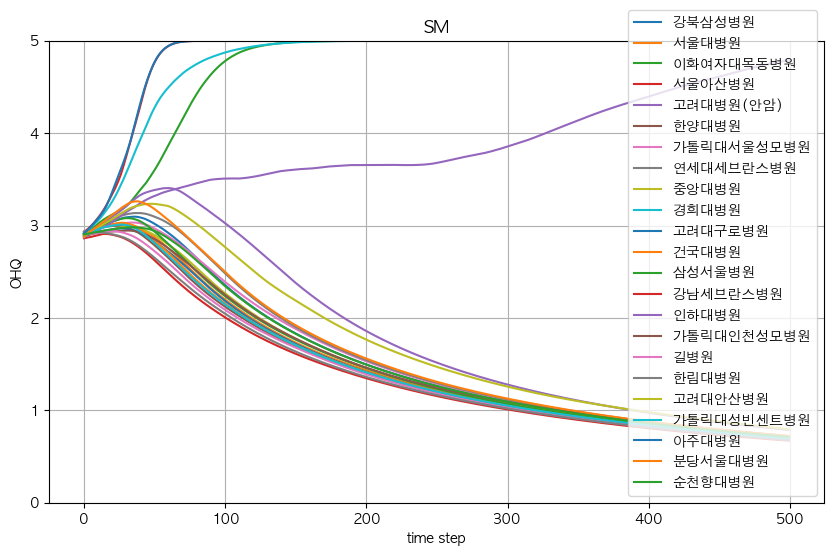

 20%|██        | 1/5 [00:00<00:00,  5.46it/s]

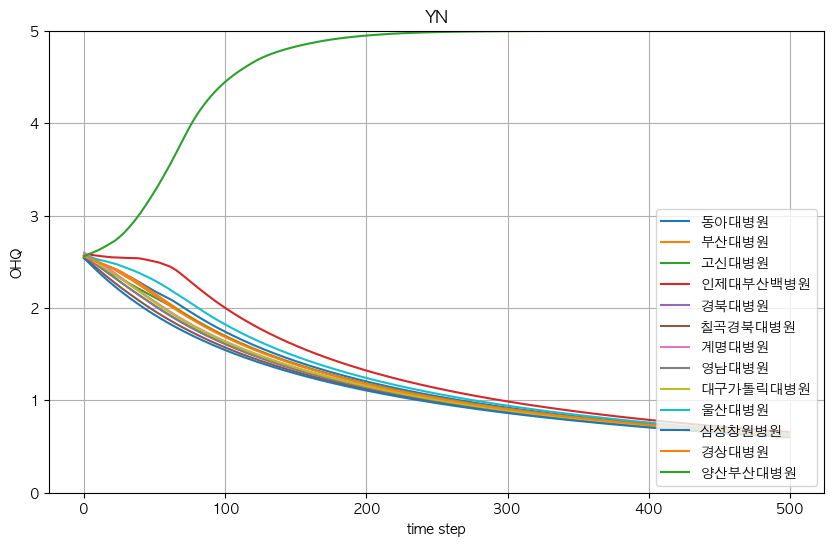

 40%|████      | 2/5 [00:00<00:00,  7.28it/s]

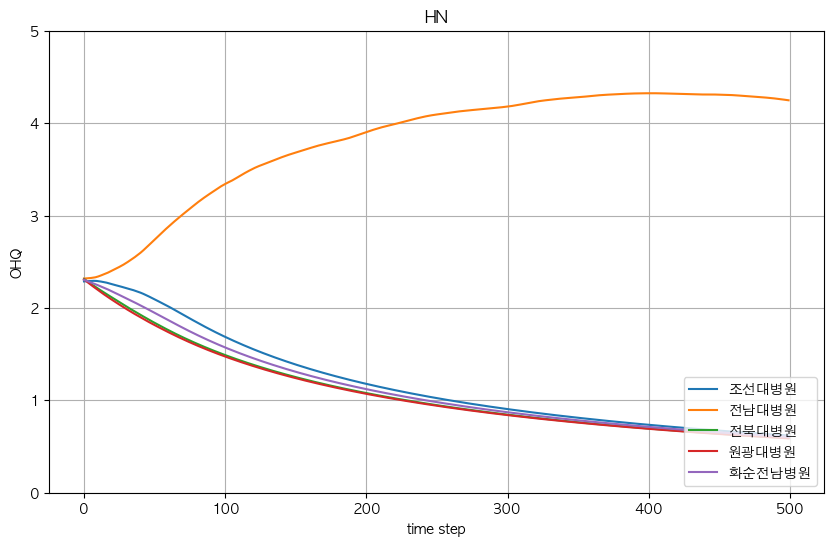

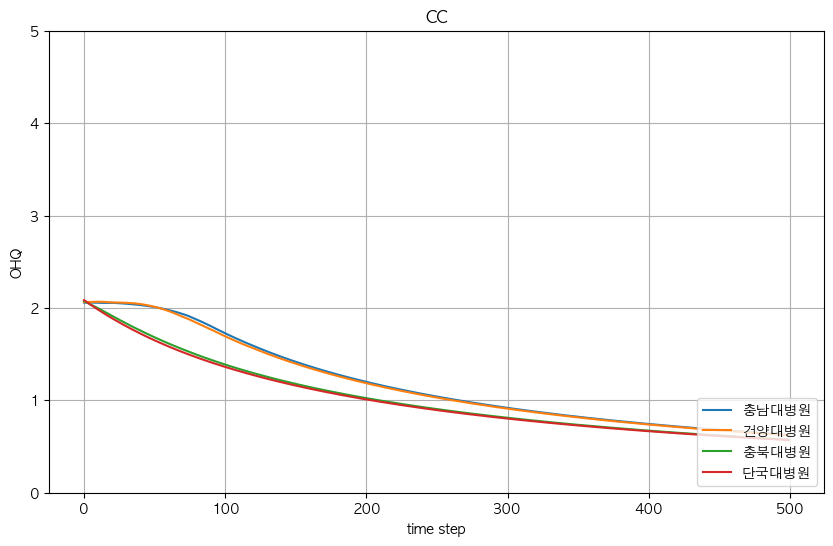

 80%|████████  | 4/5 [00:00<00:00,  9.71it/s]

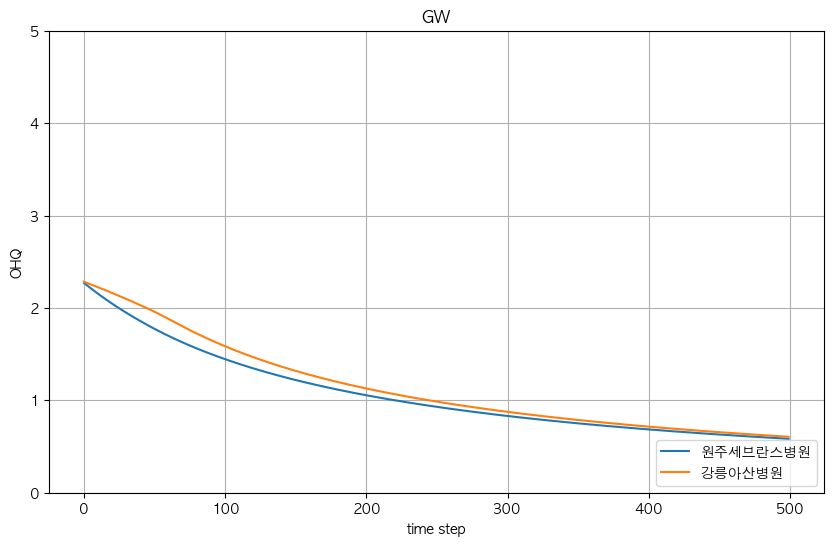

100%|██████████| 5/5 [00:00<00:00,  9.46it/s]


In [251]:
# OHQ in single region
for idx_region in tqdm(region_mapping.values()):
    nm_region = list(region_mapping.keys())[idx_region]
    list_idx_hospital = dict_target_idx_hospital[nm_region]

    plt.figure(figsize=(10, 6))

    for idx_hospital in list_idx_hospital:
        plt.plot(target_sim.achv_OHQ[:,idx_hospital]
                ,label=target_sim.df_Hospital_info.loc[target_sim.df_Hospital_info.idx_hospital == idx_hospital, 'nm_hospital'].values[0]) 
        
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.ylim(0,5)
    plt.title(list(region_mapping.keys())[idx_region])
    plt.xlabel("time step")
    plt.ylabel("OHQ")
    plt.show()

### Regional Average

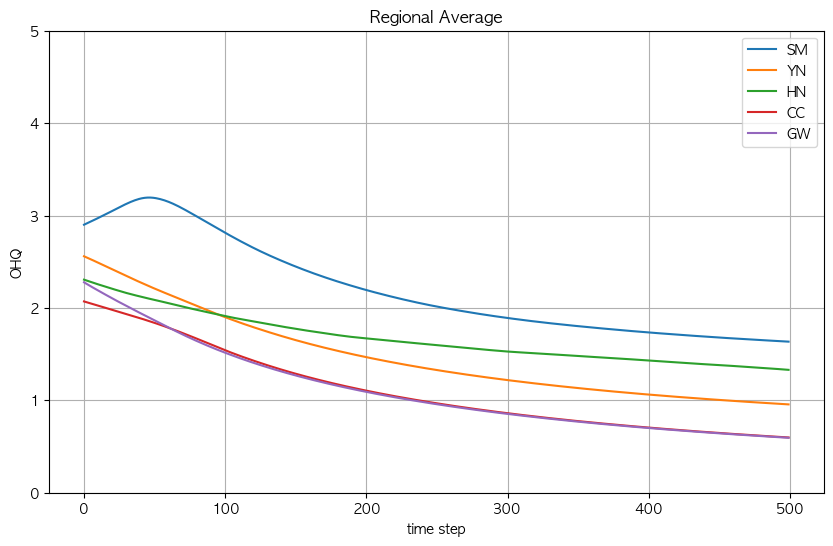

In [252]:
# mean OHQ for each region
plt.figure(figsize=(10, 6))

for key in dict_target_idx_hospital:
    plt.plot(np.mean(target_sim.achv_OHQ[:,dict_target_idx_hospital[key]], axis=1))
    
plt.legend(dict_target_idx_hospital.keys())
plt.grid(True)
plt.ylim(0,5)
plt.title("Regional Average")
plt.xlabel("time step")
plt.ylabel("OHQ")
plt.show()

## PRQ

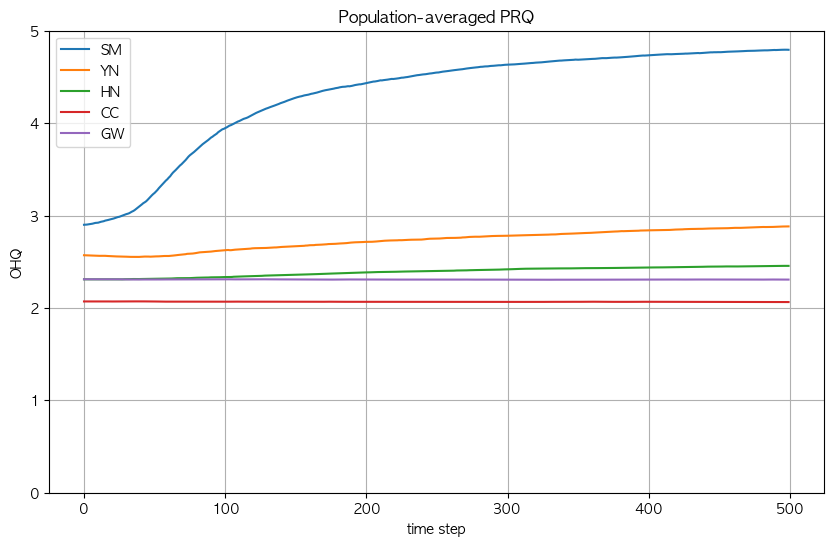

In [ ]:
# PRQ
plt.figure(figsize=(10, 6))
temp = np.mean(target_sim.achv_population_PRQ, axis=1)

for i in range(temp.shape[1]):
    plt.plot(temp[:,i])
    
plt.legend(dict_target_idx_hospital.keys())
plt.grid(True)
plt.ylim(0,5)
plt.title("Population-averaged PRQ")
plt.xlabel("time step")
plt.ylabel("PRQ")
plt.show()

## PHQ

### Within each region

  0%|          | 0/5 [00:00<?, ?it/s]

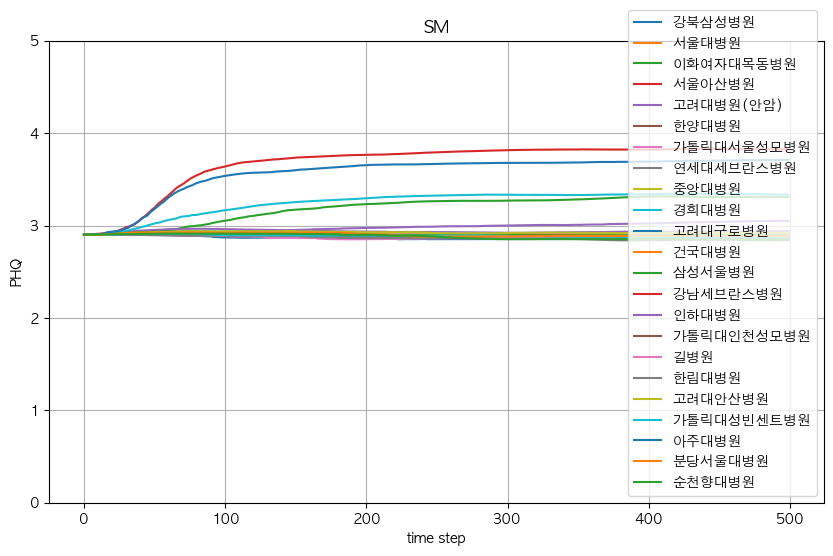

 20%|██        | 1/5 [00:01<00:04,  1.01s/it]

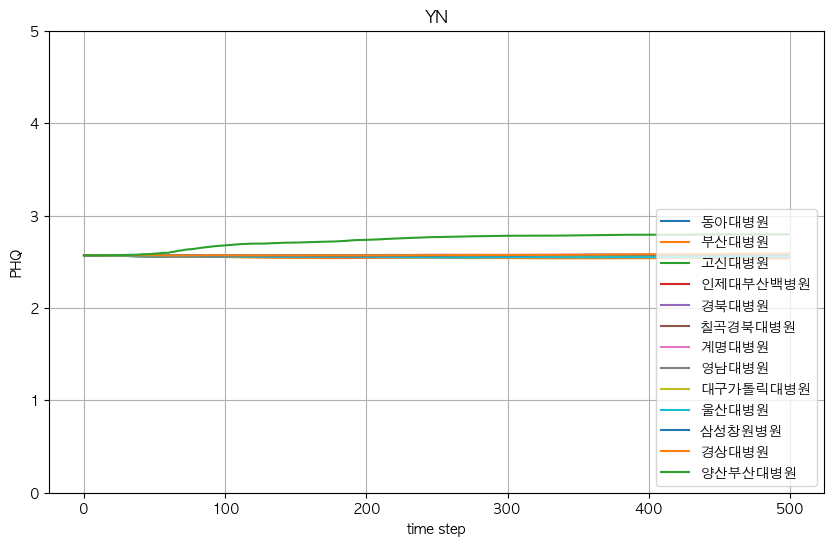

 40%|████      | 2/5 [00:01<00:02,  1.32it/s]

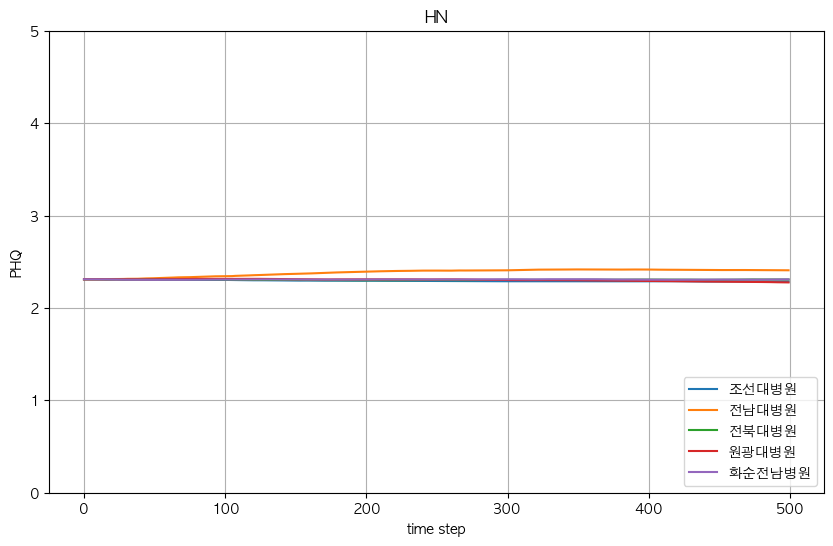

 60%|██████    | 3/5 [00:01<00:01,  1.86it/s]

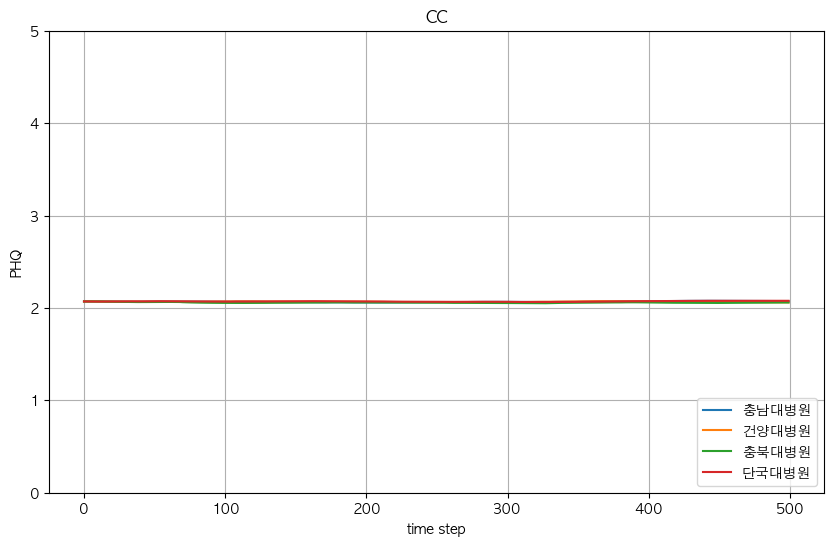

 80%|████████  | 4/5 [00:02<00:00,  2.40it/s]

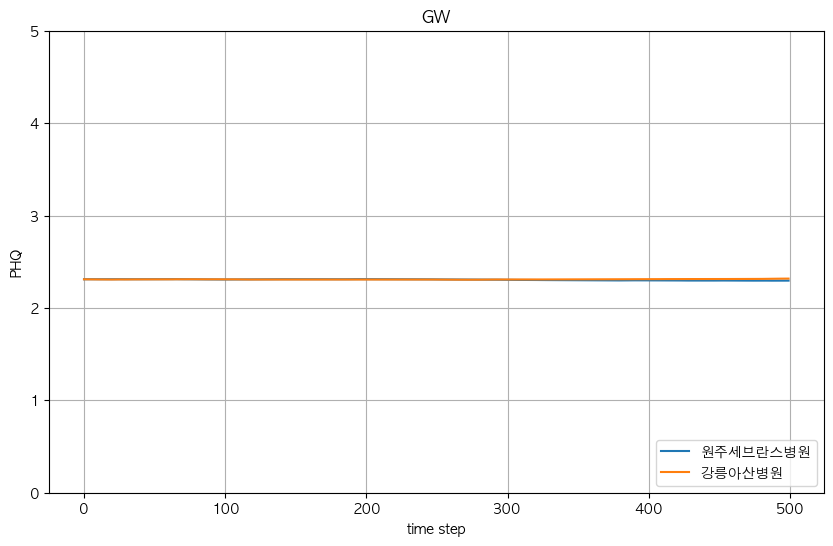

100%|██████████| 5/5 [00:02<00:00,  2.23it/s]


In [254]:
# PHQ in single region
for idx_region in tqdm(region_mapping.values()):
    nm_region = list(region_mapping.keys())[idx_region]
    list_idx_hospital = dict_target_idx_hospital[nm_region]

    plt.figure(figsize=(10, 6))

    for idx_hospital in list_idx_hospital:
        plt.plot(np.mean(target_sim.achv_population_PHQ, axis=1)[:,idx_hospital]
                ,label=target_sim.df_Hospital_info.loc[target_sim.df_Hospital_info.idx_hospital == idx_hospital, 'nm_hospital'].values[0]) 
        
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.ylim(0,5)
    plt.title(list(region_mapping.keys())[idx_region])
    plt.xlabel("time step")
    plt.ylabel("PHQ")
    plt.show()

### Regional Average

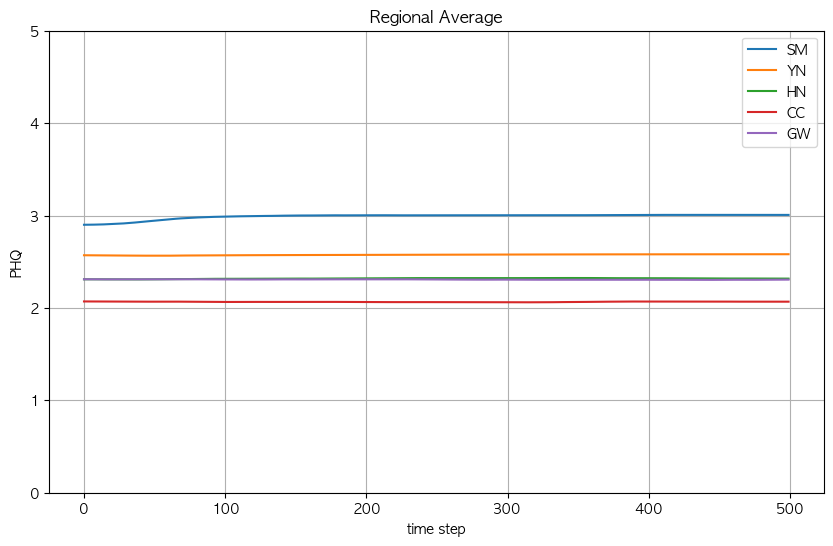

In [256]:
# mean PHQ for each region
plt.figure(figsize=(10, 6))

for key in dict_target_idx_hospital:
    plt.plot((np.mean(np.mean(target_sim.achv_population_PHQ[:,:,dict_target_idx_hospital[key]], axis=1), axis=1)))
    
plt.legend(dict_target_idx_hospital.keys())
plt.grid(True)
plt.ylim(0,5)
plt.title("Regional Average")
plt.xlabel("time step")
plt.ylabel("PHQ")
plt.show()

# Choice Probability

## Regional Choice Probability

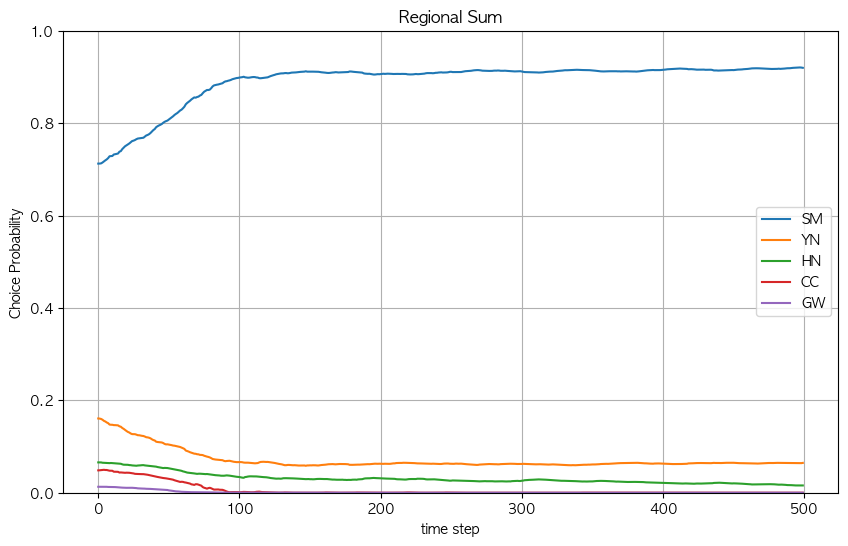

In [258]:
# Regional Choice Prob

plt.figure(figsize=(10, 6))

achv_choice_prob = np.mean(target_sim.achv_population_choice_prob, axis=1)

for idx_region in region_mapping.values():
    nm_region = list(region_mapping.keys())[idx_region]
    plt.plot(np.sum(achv_choice_prob[:,dict_target_idx_hospital[nm_region]], axis=1)
             , label=nm_region)  

plt.legend()
plt.grid(True)
plt.ylim(0,1)
plt.title("Regional Sum")
plt.xlabel("time step")
plt.ylabel("Choice Probability")
plt.show()

## Within each region

  0%|          | 0/5 [00:00<?, ?it/s]

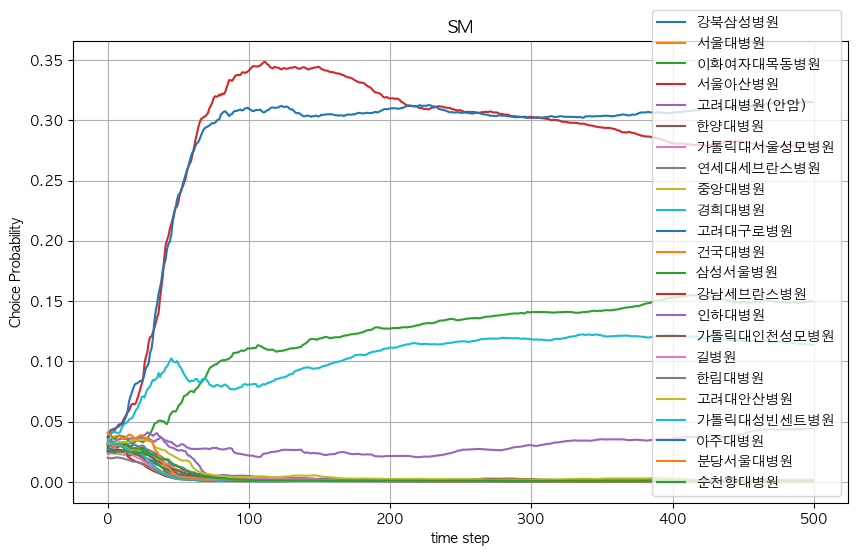

 20%|██        | 1/5 [00:00<00:00,  5.39it/s]

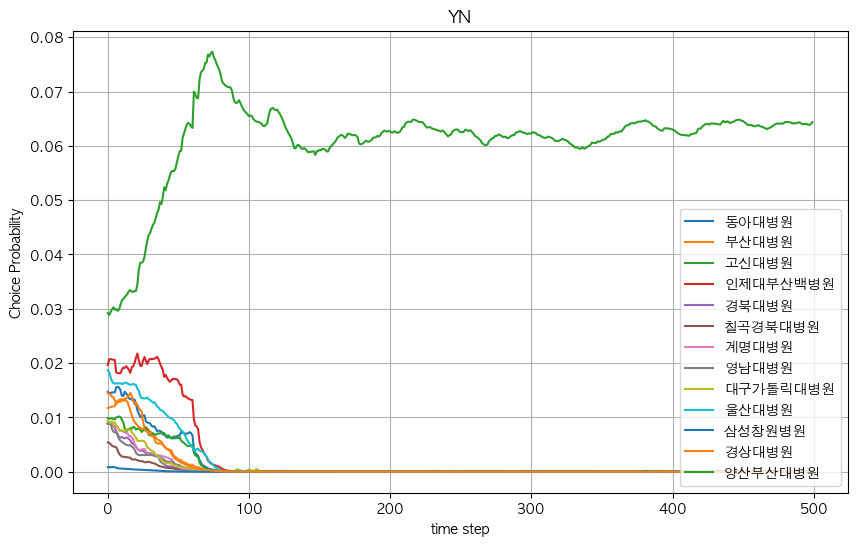

 40%|████      | 2/5 [00:00<00:00,  6.73it/s]

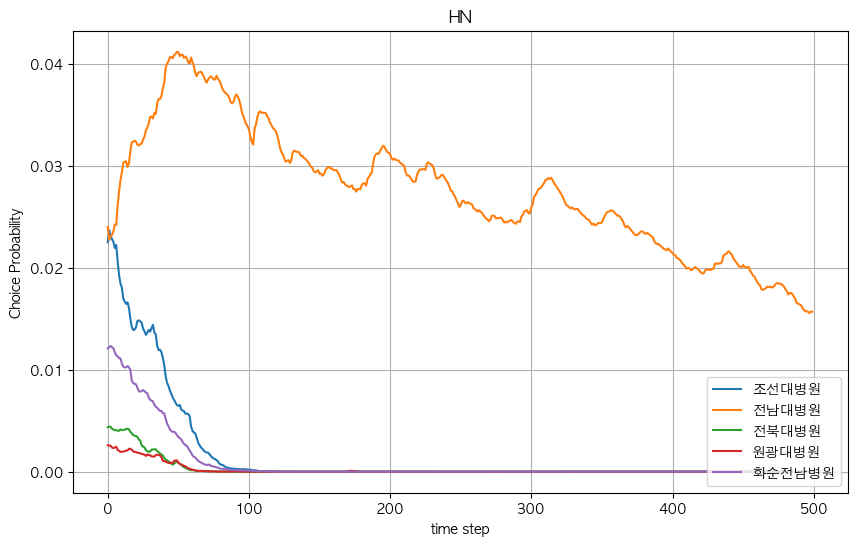

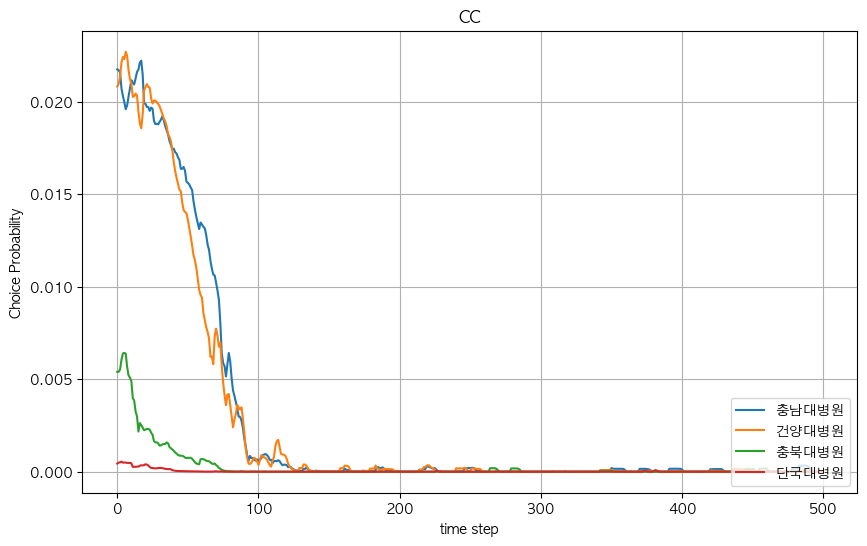

 80%|████████  | 4/5 [00:00<00:00,  9.19it/s]

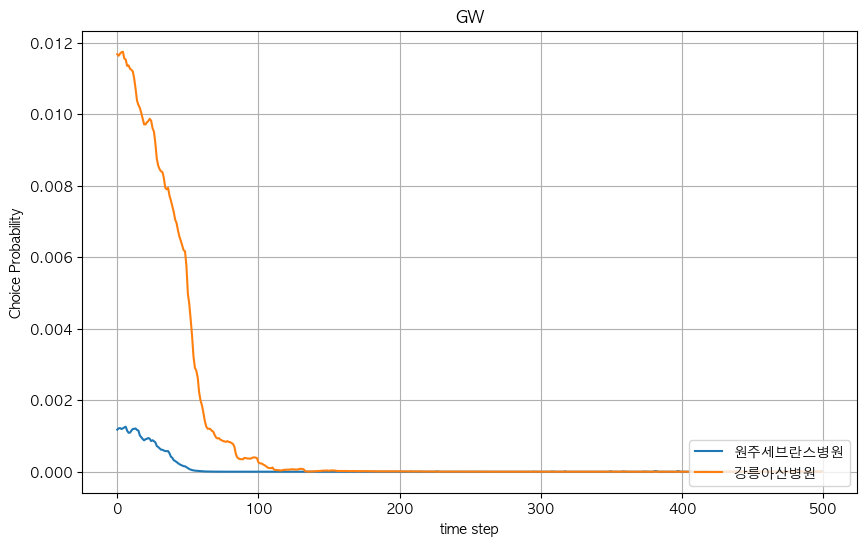

100%|██████████| 5/5 [00:00<00:00,  8.89it/s]


In [260]:
for idx_region in tqdm(region_mapping.values()):
    nm_region = list(region_mapping.keys())[idx_region]
    list_idx_hospital = dict_target_idx_hospital[nm_region]

    plt.figure(figsize=(10, 6))

    for idx_hospital in list_idx_hospital:
        plt.plot(achv_choice_prob[:,idx_hospital]
                ,label=target_sim.df_Hospital_info.loc[target_sim.df_Hospital_info.idx_hospital == idx_hospital, 'nm_hospital'].values[0])  

    plt.legend(loc='lower right')
    plt.grid(True)
    plt.title(list(region_mapping.keys())[idx_region])
    plt.xlabel("time step")
    plt.ylabel("Choice Probability")
    plt.show()

## Outmigration Probability

In [ ]:
dict_regional_choice_prob = {}
for idx_region in region_mapping.values():
    region = list(region_mapping.keys())[idx_region]
    dict_regional_choice_prob[idx_region] = np.mean(target_sim.achv_population_choice_prob[:,
                                        target_sim.df_Person_info.loc[target_sim.df_Person_info.REGION==region].idx_person.values,
                                        :], axis=1)

### Entire Population

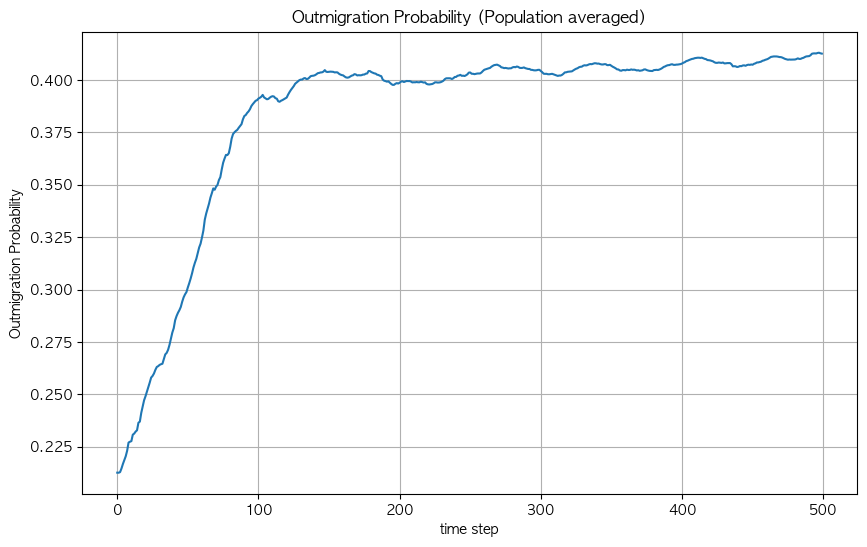

In [282]:
prob_outmigration = np.zeros((500, 5))
for idx_region in range(5):
    prob_outmigration[:, idx_region] = np.sum(dict_regional_choice_prob[idx_region][:, np.array(range(47))[~np.isin(np.array(range(47)), dict_target_idx_hospital[list(region_mapping.keys())[idx_region]])]], axis=1)

prob_outmigration_population_averaged = np.dot(prob_outmigration, target_sim.df_Person_info.groupby("idx_REGION").size().values / len(target_sim.df_Person_info))

plt.figure(figsize=(10, 6))
plt.plot(prob_outmigration_population_averaged)
plt.grid(True)
plt.title("Outmigration Probability (Population averaged)")
plt.xlabel("time step")
plt.ylabel("Outmigration Probability")
plt.show()


## For each region

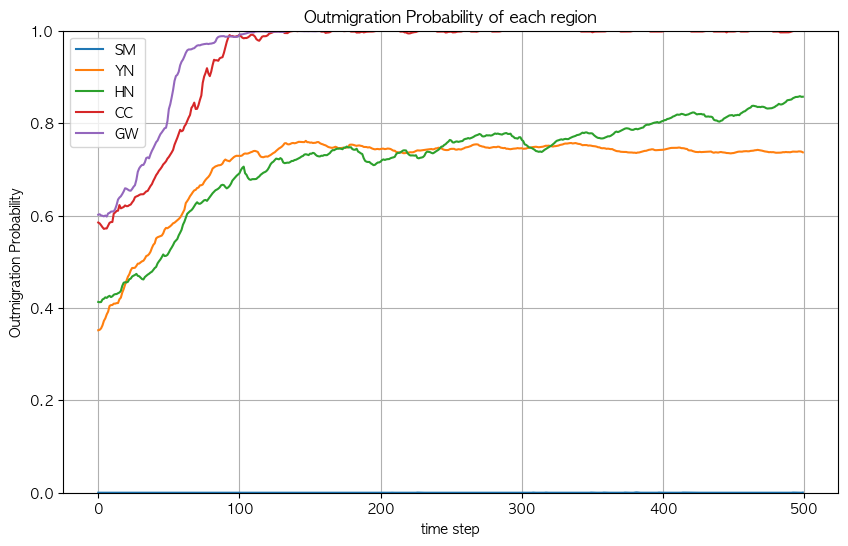

In [278]:
plt.figure(figsize=(10, 6))
plt.plot(prob_outmigration, label = region_mapping.keys())
plt.legend()
plt.grid(True)
plt.ylim(0,1)
plt.title("Outmigration Probability of each region")
plt.xlabel("time step")
plt.ylabel("Outmigration Probability")
plt.show()